# MAE Poly Loss Analysis 

In [2098]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import scipy.stats as stats
import tensorflow as tf
from sklearn.metrics import fbeta_score

In [2099]:
wd = os.getcwd()
data = os.path.join(wd, "data")
wd

'/Users/jakegwinn/Documents/argonne_F24/u.jw_analysis'

### Functions

In [2100]:
class CustomFbetaMetric(tf.keras.metrics.Metric):
    def __init__(self, beta=1, threshold=0.4, name='custom_fbeta_score', **kwargs):
        super(CustomFbetaMetric, self).__init__(name=name, **kwargs)
        self.beta = beta
        self.threshold = threshold
        
        self.precision_metric = tf.keras.metrics.Precision()
        self.recall_metric = tf.keras.metrics.Recall()

    # def discretize(self, y_true, y_pred, sample_weight=None):
    #     # Using np.where to discretize y_pred and y_true
        
    #     return y_true, y_pred

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Use numpy function for discretization
        # y_true, y_pred = self.discretize(y_true, y_pred)
        
        y_pred_disc = tf.where(y_pred >= self.threshold, 0, 1)
        y_true_disc = tf.where(y_true >= self.threshold, 0, 1)
        # print(y_true)
        # y_pred_disc = tf.where(y_pred >= self.threshold, 1, 0)
        # y_true_disc = tf.where(y_true >= self.threshold, 1, 0)
        
        # y_pred_disc = tf.where(y_pred < self.threshold, 1, 0)
        # y_true_disc = tf.where(y_true < self.threshold, 1, 0)
        
        self.precision_metric.update_state(y_true_disc, y_pred_disc, sample_weight=sample_weight)
        self.recall_metric.update_state(y_true_disc, y_pred_disc, sample_weight=sample_weight)
        
        
        # self.precision_metric.update_state(y_true, y_pred_disc, sample_weight=sample_weight)
        # self.recall_metric.update_state(y_true, y_pred_disc, sample_weight=sample_weight)
        # Update the state using the fbeta_score metric
        # self.fbeta_score.update_state(y_true, y_pred, sample_weight=sample_weight)

    def result(self):
        precision = self.precision_metric.result()
        recall = self.recall_metric.result()
        
        beta_squared = self.beta ** 2
        fbeta = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + tf.keras.backend.epsilon())
        return fbeta

    def reset_states(self):
        self.precision_metric.reset_states()
        self.recall_metric.reset_states()

In [2101]:
metric = CustomFbetaMetric()

In [2102]:
def mae_calc_thresh(dataframe, threshold):
    
    df = dataframe[dataframe["auc_true"] < threshold]
    y_true = df["auc_true"]
    y_pred = df["auc_pred"]
    
    residuals_below = y_true - y_pred
    
    df = dataframe[dataframe["auc_true"] >= threshold]
    y_true = df["auc_true"]
    y_pred = df["auc_pred"]
    
    residuals_above = y_true - y_pred
    
    return (np.mean(np.abs(residuals_below)), np.mean(np.abs(residuals_above)))

In [2103]:
def f_beta_wrapper(dataframe, threshold, b):
    y_true = dataframe["auc_true"]
    y_pred = dataframe["auc_pred"]
    
    # print(y_true)
    y_true = (threshold > y_true).astype(int)
    # print(y_true)
    y_pred = (threshold > y_pred).astype(int)

    return fbeta_score(y_true=y_true, y_pred=y_pred, beta=b)
    

### Plot Functions

In [2104]:
def residual_plot(data, alpha):
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f"Residual Plot\nAlpha = {alpha}")
    
    plt.show()

In [2105]:
def res_v_true(data, alpha, auc_max=1):
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    mask = (y_true <= auc_max)
    y_true_filtered = y_true[mask]
    residuals_filtered = residuals[mask]
    
    
    coefficients = np.polyfit(y_true_filtered, residuals_filtered, deg=1)
    slope, intercept = coefficients
    best_fit_line = slope * y_true_filtered + intercept
    
    # Plot the best-fit line
    plt.plot(y_true_filtered, best_fit_line, color="red", label=f"Best Fit (True ≤ {auc_max})")
    
    plt.scatter(y_true, residuals)
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f"Residuals vs True Values Plot\nAlpha = {alpha}")
    plt.show()

In [2106]:
def error_distrib(data, alpha):
    
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title(f"Error Distribution\nAlpha = {alpha}")
    
    plt.show()

In [2107]:
def error_abs_distrib(data, alpha):
    
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    sns.histplot(np.abs(residuals), kde=True)
    plt.xlabel("Residuals")
    plt.title(f"Absolute Value Error Distribution\nAlpha = {alpha}")
    
    plt.show()

In [2108]:
def qqres_plot(data, alpha):
    
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    studentized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

    fig = sm.qqplot(studentized_residuals, line='45')
    # Customize plot
    plt.title(f"QQ Plot of Studentized Residuals\nAlpha = {alpha}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

### Ranking Functions

In [2109]:
def make_rank_df(test_data):
    unique_samps = test_data["improve_sample_id"].unique()

    data_dict = {}

    for samp in unique_samps:
        true_order = test_data[test_data["improve_sample_id"] == samp].sort_values(by="auc_true", ascending = False).reset_index(drop = True)
        pred_order = true_order.sort_values(by="auc_pred", ascending = False)
        
        data_dict[samp] = {"true": true_order, "pred": pred_order}
        # break

    # print(data_dict)

    key_list = ["improve_sample_id", "spearman_all", "kendall_tau_val", "kendall_tau_pval"]
    ranking_dict = {key: [] for key in key_list}

    for key in data_dict.keys(): 
            
            rank_actual = data_dict[key]["true"]
            rank_predict = data_dict[key]["true"]
            
            sum1 = 0
        # Sum of difference squares (Σ d^2)
            sum2 = 0
            all = len(rank_actual)
            
            for i in range(0, all):
                # drug = rank_actual.iloc[i][2]
                # print("drug ", drug)
                # match = rank_predict.loc[rank_predict["improve_chem_id"] == drug]
                # print("match ", match.index.item())
                true_item = rank_actual["improve_chem_id"][i]
                # print(true_item)
                # print(rank_predict["improve_chem_id"][rank_predict["improve_chem_id"] == true_item])
                predicted_rank = rank_predict["improve_chem_id"][rank_predict["improve_chem_id"] == true_item].index[0]

                diff  = abs(i - predicted_rank)
                
                sum1 += diff
                diff2 = diff ** 2
                # print("diff2 ", diff2)
                sum2 += diff2
                # print("match ", str(match), " is ", )
            spearman_all = 1 - 6*sum2/(all*(all**2 - 1))
            ########################################################
            ranks_true = rank_actual.index.to_list()
            ranks_pred = rank_predict.index.to_list()
            kt = stats.kendalltau(ranks_true, ranks_pred)
            #######################################################
            
            ranking_dict["improve_sample_id"].append(key)
            ranking_dict["spearman_all"].append(spearman_all)
            ranking_dict["kendall_tau_val"].append(kt[0])
            ranking_dict["kendall_tau_pval"].append(kt[1])
            
    return pd.DataFrame(ranking_dict)

In [2110]:
def range_metrics(data, lower_quantile=0.1, upper_quantile=0.9):
    """
    Calculate metrics for the lower and upper quantiles of the target.
    
    Parameters:
    - lower_quantile: float, quantile threshold for the lower range.
    - upper_quantile: float, quantile threshold for the upper range.
    
    Returns:
    - dict with MAE and coverage for lower and upper quantiles.
    """
    
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    # Lower quantile
    lower_threshold = np.quantile(y_true, lower_quantile)
    indices_low = np.where(y_true <= lower_threshold)[0]
    mae_lower = np.mean(np.abs(y_true[indices_low] - y_pred[indices_low]))
    coverage_lower = np.sum(y_pred[indices_low] <= lower_threshold) / len(indices_low)

    # Upper quantile
    upper_threshold = np.quantile(y_true, upper_quantile)
    indices_high = np.where(y_true >= upper_threshold)[0]
    mae_upper = np.mean(np.abs(y_true[indices_high] - y_pred[indices_high]))
    coverage_upper = np.sum(y_pred[indices_high] >= upper_threshold) / len(indices_high)

    return {
        "Lower Quantile MAE": mae_lower,
        "Lower Quantile Coverage": coverage_lower,
        "Upper Quantile MAE": mae_upper,
        "Upper Quantile Coverage": coverage_upper,
    }


In [2111]:
def mae_intervals(data, key, plot=False):
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    bins = np.arange(0, 1.1, 0.1)  # Bins from 0 to 1 in steps of 0.1
    bin_labels = [f"[{bins[i]:.1f}, {bins[i+1]:.1f})" for i in range(len(bins) - 1)]

    # Assign each observation to a bin
    bin_indices = np.digitize(y_true, bins, right=False) - 1  # -1 to make bins 0-indexed
    # Calculate MAE for each bin
    mae_per_bin = []
    count_per_bin = []
    for i in range(len(bins) - 1):
        indices_in_bin = np.where(bin_indices == i)[0]
        if len(indices_in_bin) > 0:
            mae = np.mean(np.abs(y_true[indices_in_bin] - y_pred[indices_in_bin]))
        else:
            mae = np.nan  # No data in this bin
        mae_per_bin.append(mae)
        count_per_bin.append(len(indices_in_bin))
    results = pd.DataFrame({
        "Interval": bin_labels,
        "MAE": mae_per_bin, 
        "n": count_per_bin
    })
    
    results["loss"] = key
    if plot:
        plt.bar(bin_labels, mae_per_bin, edgecolor='black')
        plt.xlabel("AUC Intervals")
        plt.ylabel("MAE")
        plt.title(f"MAE Across AUC Intervals\n{key}")
        plt.yticks(np.arange(0, 0.4, 0.01))
        plt.xticks(rotation=45)
        plt.show()
        
    return(results)

## All Dataframes

In [2112]:
all_dfs = {}

## Base Case: Polynomial with degree 0 &rarr; MAE

In [2113]:
folder = os.path.join(data, "basecase")
os.listdir(folder)
test_base = pd.read_csv(os.path.join(folder, "test_y_predicted_mae.csv"))
all_dfs["Base Case"] = test_base
test_base.to_csv("test.tsv", sep="\t", index=False)

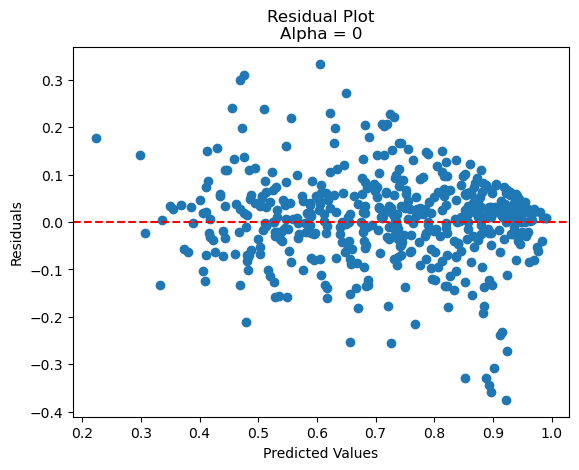

In [2114]:
residual_plot(test_base, alpha=0)

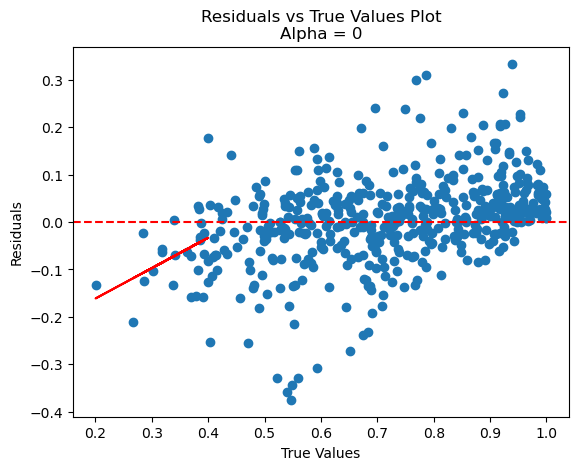

In [2115]:
res_v_true(test_base, alpha=0, auc_max=0.4)

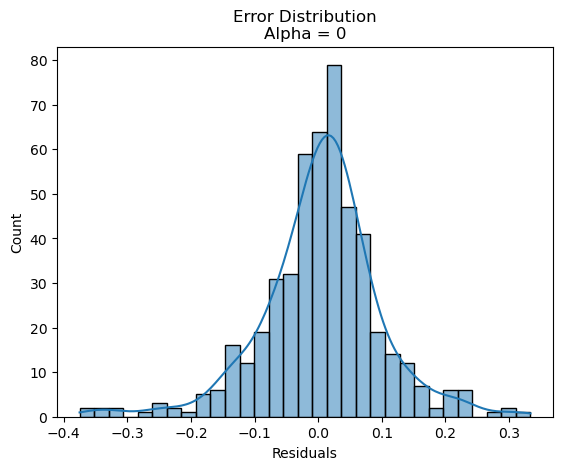

In [2116]:
error_distrib(test_base, alpha=0)

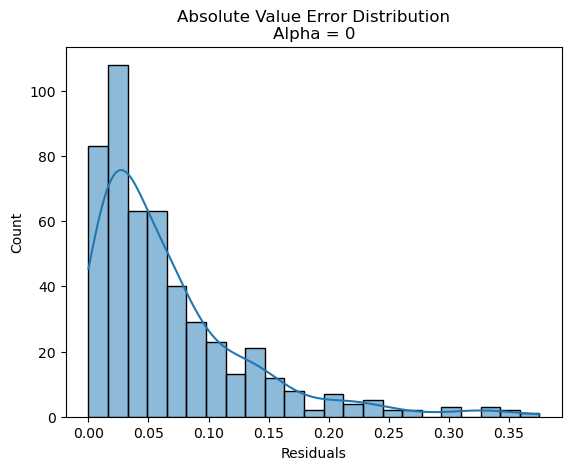

In [2117]:
error_abs_distrib(test_base, alpha=0)

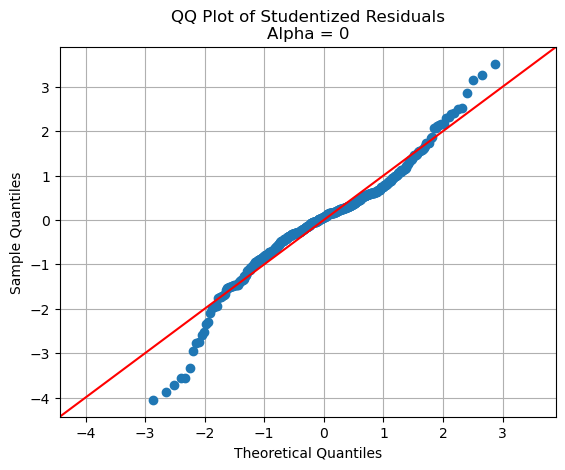

In [2118]:
qqres_plot(test_base, alpha=0)

In [2119]:
make_rank_df(test_base)


/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/3505800086.py:45: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


,improve_sample_id,spearman_all,kendall_tau_val,kendall_tau_pval
0,ACH-000948,1.0,1.0,0.083333
1,ACH-000219,NaN,NaN,NaN
2,ACH-000222,1.0,1.0,0.016667
3,ACH-000548,1.0,1.0,1.000000
4,ACH-000288,1.0,1.0,0.002778
...,...,...,...,...
253,ACH-000738,NaN,NaN,NaN
254,ACH-000861,NaN,NaN,NaN
255,ACH-000648,NaN,NaN,NaN
256,ACH-000638,NaN,NaN,NaN


In [2120]:
f_beta_wrapper(test_base, 0.5, 4)

0.689594356261023

## Polynomial with Degree 2

In [2121]:
folder = os.path.join(data, "maep2")
os.listdir(folder)
test_p2 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_maep2.csv"))
all_dfs["MAE Poly 2"] = test_p2
test_p2


,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.8857
1,ACH-000219,Drug_1163,0.9061,0.9061,0.8580
2,ACH-000222,Drug_1163,0.9846,0.9846,0.9050
3,ACH-000548,Drug_1163,0.9246,0.9246,0.8772
4,ACH-000288,Drug_1163,0.9222,0.9222,0.8750
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.6236
490,ACH-000704,Drug_1127,0.5981,0.5981,0.5011
491,ACH-000042,Drug_1127,0.6009,0.6009,0.6299
492,ACH-000677,Drug_1127,0.5345,0.5345,0.5410


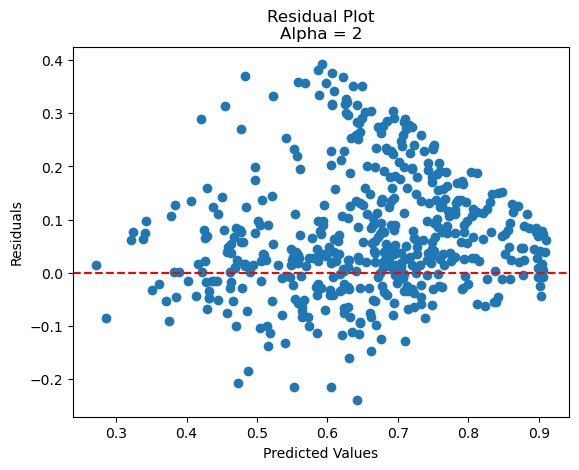

In [2122]:
residual_plot(test_p2, alpha=2)

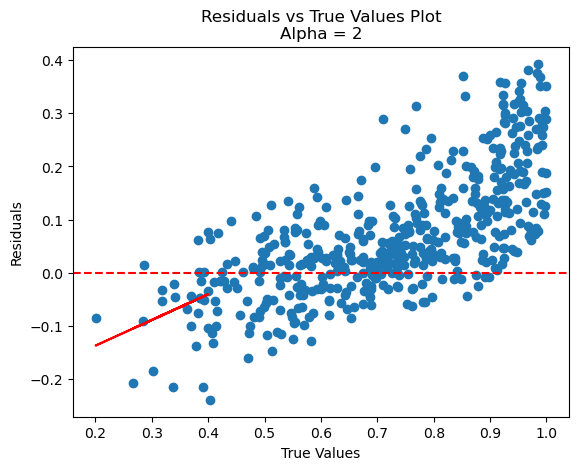

In [2123]:
res_v_true(test_p2, alpha=2, auc_max=0.4)

Line of best fit with lower values to see if push up

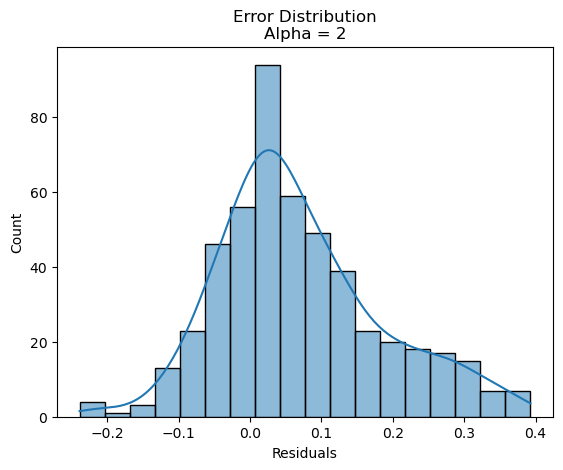

In [2124]:
error_distrib(test_p2, alpha=2)

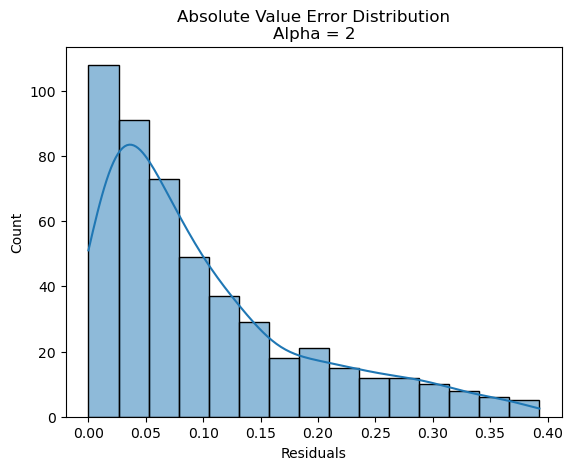

In [2125]:
error_abs_distrib(test_p2, alpha=2)

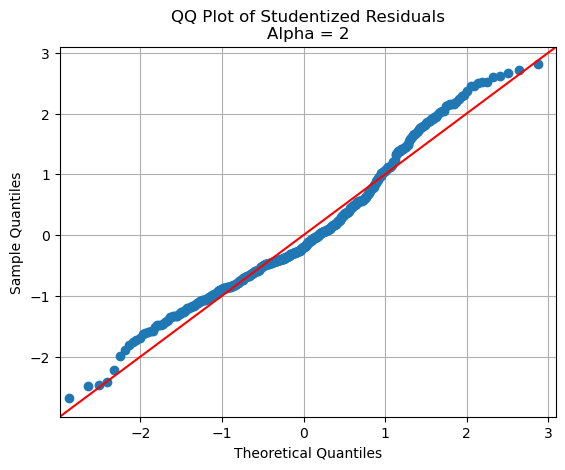

In [2126]:
qqres_plot(test_p2, alpha=2)

In [2127]:
df = test_p2[test_p2["auc_true"] < 0.4]
y_true = df["auc_true"]
y_pred = df["auc_pred"]
    
residuals = y_true - y_pred
np.mean(np.abs(residuals))

0.07703333333333333

In [2128]:
f_beta_wrapper(test_p2, 0.5, 4)

0.7262423714036618

In [2129]:
make_rank_df(test_p2)

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/3505800086.py:45: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


,improve_sample_id,spearman_all,kendall_tau_val,kendall_tau_pval
0,ACH-000948,1.0,1.0,0.083333
1,ACH-000219,NaN,NaN,NaN
2,ACH-000222,1.0,1.0,0.016667
3,ACH-000548,1.0,1.0,1.000000
4,ACH-000288,1.0,1.0,0.002778
...,...,...,...,...
253,ACH-000738,NaN,NaN,NaN
254,ACH-000861,NaN,NaN,NaN
255,ACH-000648,NaN,NaN,NaN
256,ACH-000638,NaN,NaN,NaN


## Polynomial with Degree 4

In [2130]:
folder = os.path.join(data, "maep4")
os.listdir(folder)
test_p4 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_maep4.csv"))
all_dfs["MAE Poly 4"] = test_p4
test_p4

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.5651
1,ACH-000219,Drug_1163,0.9061,0.9061,0.4688
2,ACH-000222,Drug_1163,0.9846,0.9846,0.6355
3,ACH-000548,Drug_1163,0.9246,0.9246,0.5474
4,ACH-000288,Drug_1163,0.9222,0.9222,0.5184
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.5652
490,ACH-000704,Drug_1127,0.5981,0.5981,0.4362
491,ACH-000042,Drug_1127,0.6009,0.6009,0.4850
492,ACH-000677,Drug_1127,0.5345,0.5345,0.5168


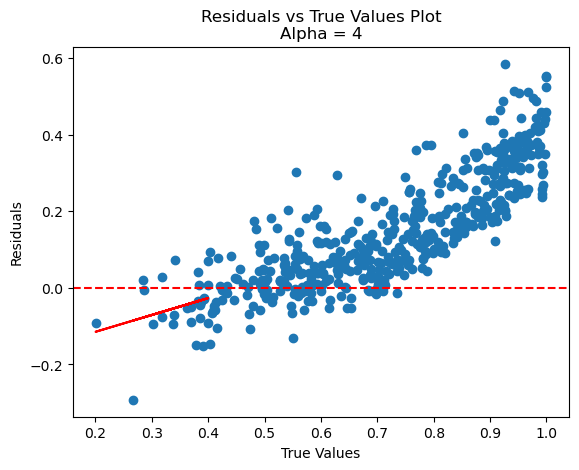

In [2131]:
res_v_true(test_p4, alpha=4, auc_max=0.4)

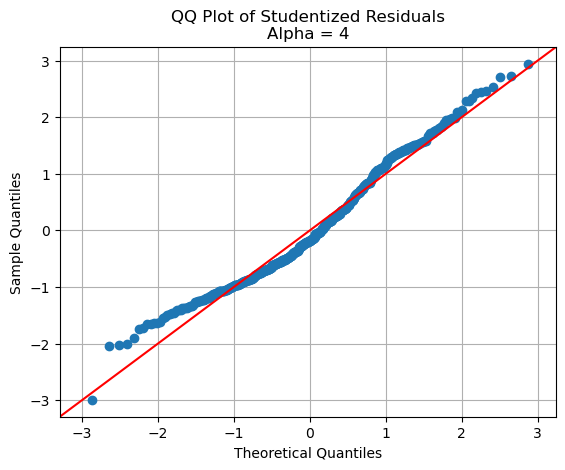

In [2132]:
qqres_plot(test_p4, alpha=4)

- zero inflated models --> logistic regression 
- log odds transformation 
    - Data transformation
- 

In [2133]:
make_rank_df(test_p4)

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/3505800086.py:45: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


,improve_sample_id,spearman_all,kendall_tau_val,kendall_tau_pval
0,ACH-000948,1.0,1.0,0.083333
1,ACH-000219,NaN,NaN,NaN
2,ACH-000222,1.0,1.0,0.016667
3,ACH-000548,1.0,1.0,1.000000
4,ACH-000288,1.0,1.0,0.002778
...,...,...,...,...
253,ACH-000738,NaN,NaN,NaN
254,ACH-000861,NaN,NaN,NaN
255,ACH-000648,NaN,NaN,NaN
256,ACH-000638,NaN,NaN,NaN


In [2134]:
f_beta_wrapper(test_p4, 0.5, 4)

0.8163437236731256

## Huber Loss

In [2135]:
# data
# folder = os.path.join(data, "huber")
# os.listdir(folder)
# test_hube = pd.read_csv(os.path.join(folder, "test_y_data_predicted_hube.csv"))
# test_hube

# resid_hube = test_hube["auc_true"] - test_hube["auc_pred"]
# resid_p2 = test_p2["auc_true"] - test_p2["auc_pred"]

# resid_hube == resid_p2

In [2136]:
# residual_plot(test_hube, "NA")

In [2137]:
# res_v_true(test_hube, "NA")

In [2138]:
# qqres_plot(test_hube, "NA")

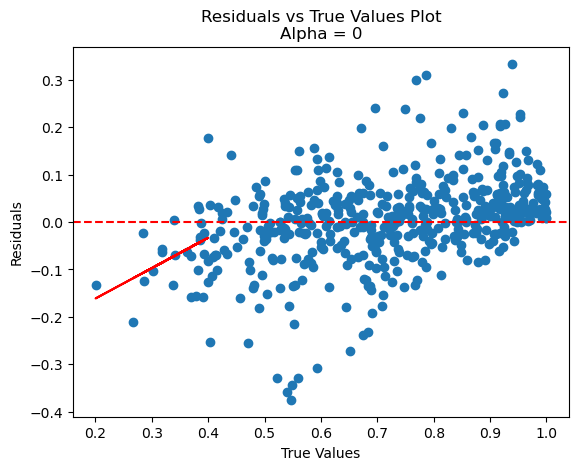

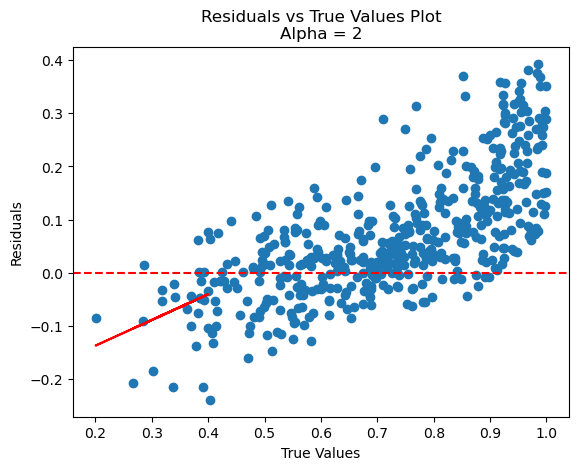

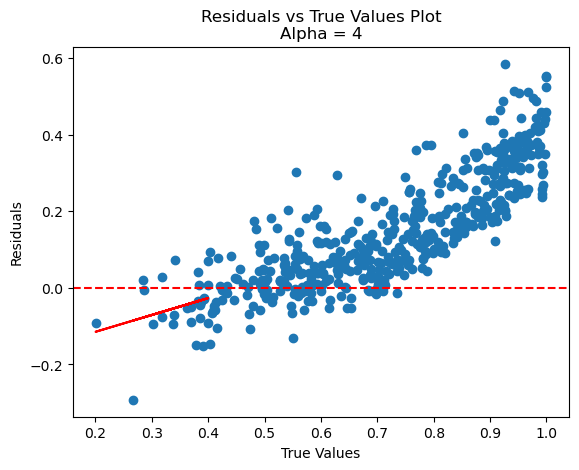

In [2139]:
res_v_true(test_base, alpha=0, auc_max=0.4)
res_v_true(test_p2, alpha=2, auc_max=0.4)
res_v_true(test_p4, alpha=4, auc_max=0.4)

## Exponential Loss

In [2140]:
folder = os.path.join(data, "exp4")
os.listdir(folder)
test_e4 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_exp4.csv"))
all_dfs["MAE Exponential 4"] = test_e4
test_e4

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.9492
1,ACH-000219,Drug_1163,0.9061,0.9061,0.9569
2,ACH-000222,Drug_1163,0.9846,0.9846,0.9496
3,ACH-000548,Drug_1163,0.9246,0.9246,0.9449
4,ACH-000288,Drug_1163,0.9222,0.9222,0.9623
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.6554
490,ACH-000704,Drug_1127,0.5981,0.5981,0.4544
491,ACH-000042,Drug_1127,0.6009,0.6009,0.6411
492,ACH-000677,Drug_1127,0.5345,0.5345,0.5311


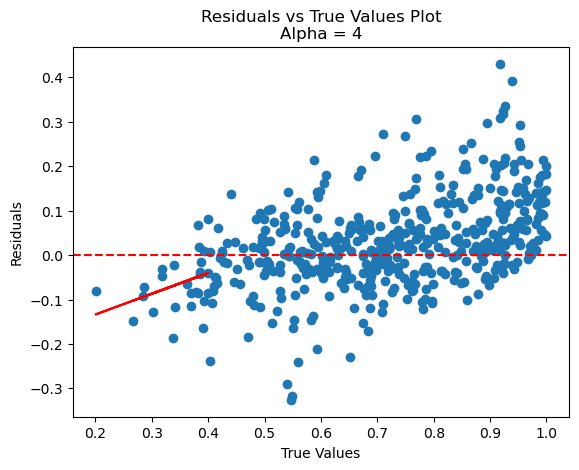

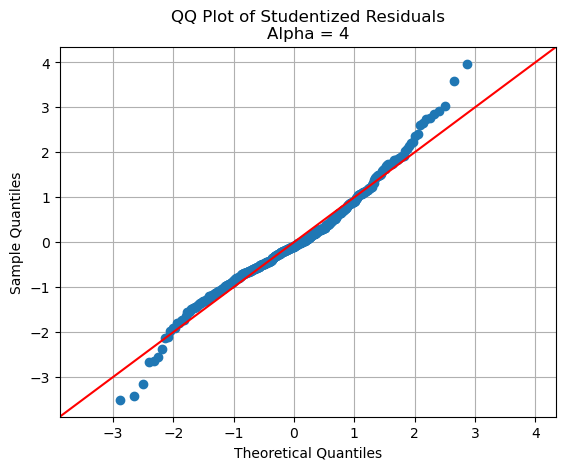

In [2141]:
res_v_true(test_e4, 4, auc_max=0.4)
qqres_plot(test_e4, 4)

In [2142]:
make_rank_df(test_e4)

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/3505800086.py:45: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


,improve_sample_id,spearman_all,kendall_tau_val,kendall_tau_pval
0,ACH-000948,1.0,1.0,0.083333
1,ACH-000219,NaN,NaN,NaN
2,ACH-000222,1.0,1.0,0.016667
3,ACH-000548,1.0,1.0,1.000000
4,ACH-000288,1.0,1.0,0.002778
...,...,...,...,...
253,ACH-000738,NaN,NaN,NaN
254,ACH-000861,NaN,NaN,NaN
255,ACH-000648,NaN,NaN,NaN
256,ACH-000638,NaN,NaN,NaN


## Exponential 7

In [2143]:
folder = os.path.join(data, "exp7")
os.listdir(folder)
test_e7 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_exp7.csv"))
all_dfs["MAE Exponential 7"] = test_e7
test_e7

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.9408
1,ACH-000219,Drug_1163,0.9061,0.9061,0.9081
2,ACH-000222,Drug_1163,0.9846,0.9846,0.9532
3,ACH-000548,Drug_1163,0.9246,0.9246,0.9279
4,ACH-000288,Drug_1163,0.9222,0.9222,0.9201
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.6373
490,ACH-000704,Drug_1127,0.5981,0.5981,0.4020
491,ACH-000042,Drug_1127,0.6009,0.6009,0.5259
492,ACH-000677,Drug_1127,0.5345,0.5345,0.4723


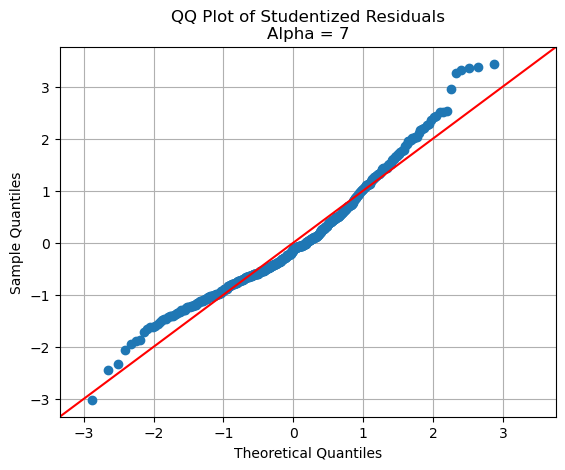

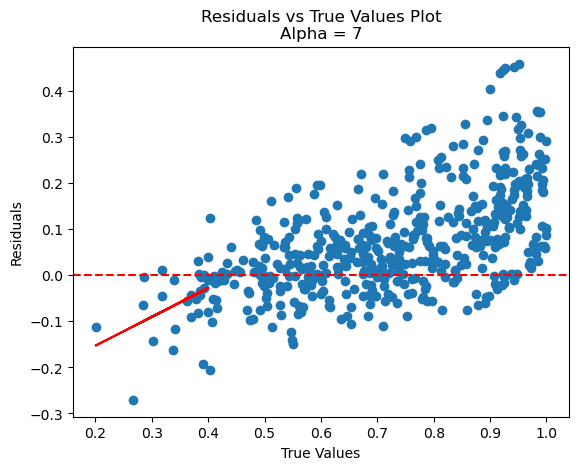

In [2144]:
qqres_plot(test_e7, 7)
res_v_true(test_e7, 7, auc_max=0.4)

In [2145]:
make_rank_df(test_e7)

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/3505800086.py:45: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


,improve_sample_id,spearman_all,kendall_tau_val,kendall_tau_pval
0,ACH-000948,1.0,1.0,0.083333
1,ACH-000219,NaN,NaN,NaN
2,ACH-000222,1.0,1.0,0.016667
3,ACH-000548,1.0,1.0,1.000000
4,ACH-000288,1.0,1.0,0.002778
...,...,...,...,...
253,ACH-000738,NaN,NaN,NaN
254,ACH-000861,NaN,NaN,NaN
255,ACH-000648,NaN,NaN,NaN
256,ACH-000638,NaN,NaN,NaN


In [2146]:
print(mae_calc_thresh(test_base, 0.5))
print(mae_calc_thresh(test_p2, 0.5))
print(mae_calc_thresh(test_p4, 0.5))
print(mae_calc_thresh(test_e4, 0.5))
print(mae_calc_thresh(test_e7, 0.5))


(0.07708059701492537, 0.06541967213114754)
(0.0649, 0.10456978922716627)
(0.05889850746268656, 0.1802648711943794)
(0.06444328358208956, 0.0796096018735363)
(0.053726865671641796, 0.1044559718969555)


## Log Cosh

In [2147]:
folder = os.path.join(data, "lc_real")
os.listdir(folder)
test_lc = pd.read_csv(os.path.join(folder, "test_y_data_predicted_logcosh_real.csv"))
all_dfs["Log Cosh"] = test_lc
test_lc

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.9442
1,ACH-000219,Drug_1163,0.9061,0.9061,0.9087
2,ACH-000222,Drug_1163,0.9846,0.9846,0.9236
3,ACH-000548,Drug_1163,0.9246,0.9246,0.9160
4,ACH-000288,Drug_1163,0.9222,0.9222,0.9570
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.6080
490,ACH-000704,Drug_1127,0.5981,0.5981,0.4916
491,ACH-000042,Drug_1127,0.6009,0.6009,0.6324
492,ACH-000677,Drug_1127,0.5345,0.5345,0.5424


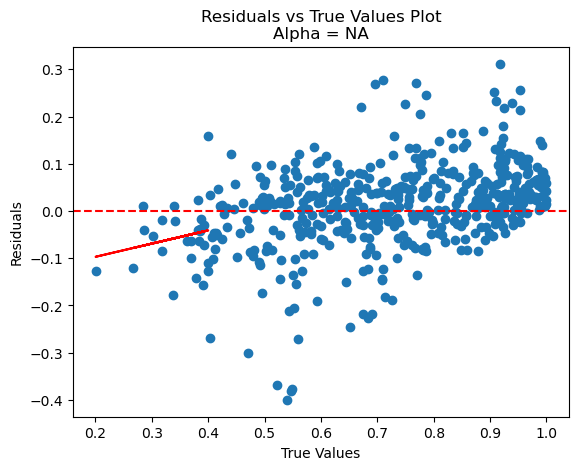

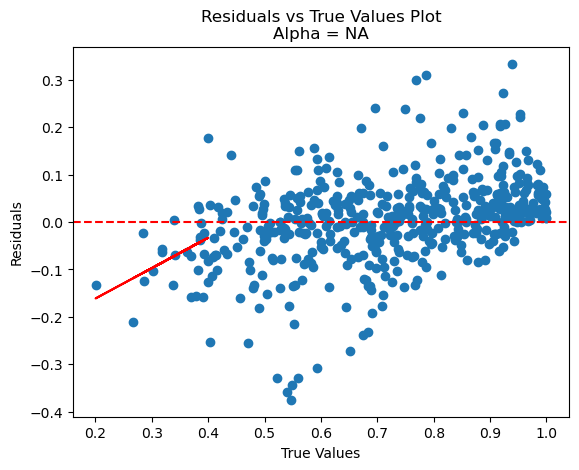

In [2148]:
res_v_true(test_lc, "NA", 0.4)
res_v_true(test_base, "NA", 0.4)

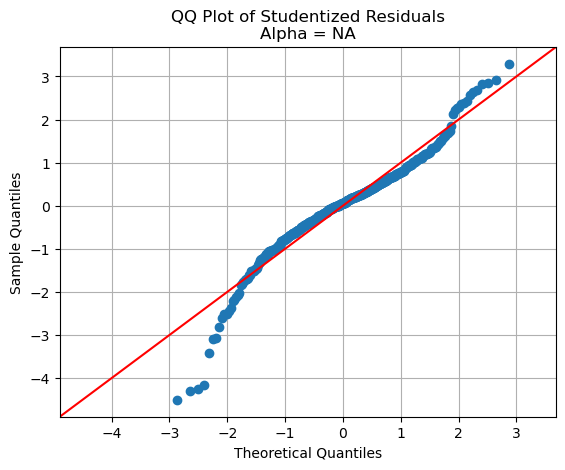

In [2149]:
qqres_plot(test_lc, "NA")

In [2150]:
print(mae_calc_thresh(test_lc, 0.5))


(0.06687611940298509, 0.06595854800936768)


In [2151]:
f_beta_wrapper(test_lc, 0.5, 4)

0.743006993006993

## MSE Poly 2

In [2152]:
folder = os.path.join(data, "msep2")
os.listdir(folder)
test_msep2 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_msep2.csv"))
all_dfs["MSE Poly 2"] = test_msep2
test_msep2

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.8923
1,ACH-000219,Drug_1163,0.9061,0.9061,0.8583
2,ACH-000222,Drug_1163,0.9846,0.9846,0.9042
3,ACH-000548,Drug_1163,0.9246,0.9246,0.8726
4,ACH-000288,Drug_1163,0.9222,0.9222,0.8866
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.6073
490,ACH-000704,Drug_1127,0.5981,0.5981,0.4341
491,ACH-000042,Drug_1127,0.6009,0.6009,0.5713
492,ACH-000677,Drug_1127,0.5345,0.5345,0.4977


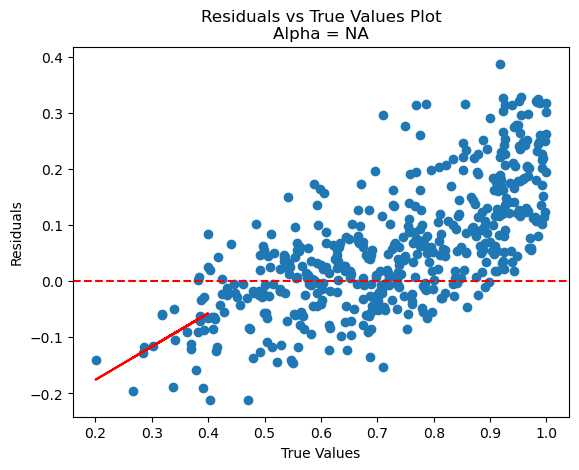

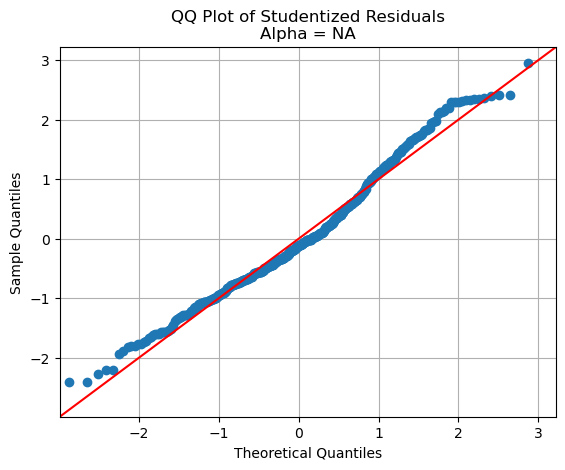

In [2153]:
res_v_true(test_msep2, "NA", 0.4)
qqres_plot(test_msep2, "NA")

In [2154]:
print(mae_calc_thresh(test_msep2, 0.5))
print(f_beta_wrapper(test_msep2, 0.5, 4))

(0.07003731343283581, 0.09889718969555034)
0.7151621384750219


## MSE BASE

In [2155]:
folder = os.path.join(data, "msep0")
os.listdir(folder)
test_msep0 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_msep0.csv"))
all_dfs["MSE Base"] = test_msep0
test_msep0

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.9570
1,ACH-000219,Drug_1163,0.9061,0.9061,0.9337
2,ACH-000222,Drug_1163,0.9846,0.9846,0.9510
3,ACH-000548,Drug_1163,0.9246,0.9246,0.9445
4,ACH-000288,Drug_1163,0.9222,0.9222,0.9593
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.6130
490,ACH-000704,Drug_1127,0.5981,0.5981,0.5088
491,ACH-000042,Drug_1127,0.6009,0.6009,0.6127
492,ACH-000677,Drug_1127,0.5345,0.5345,0.5406


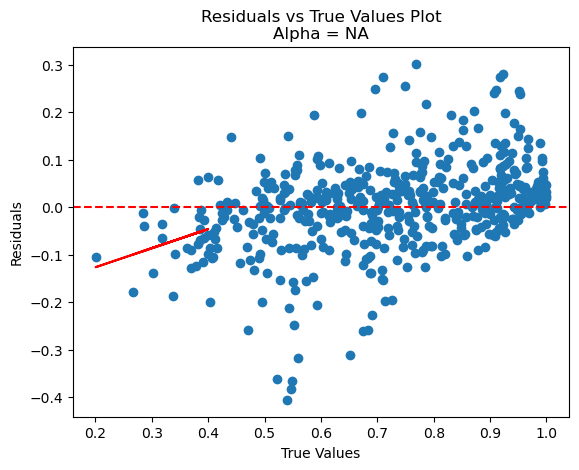

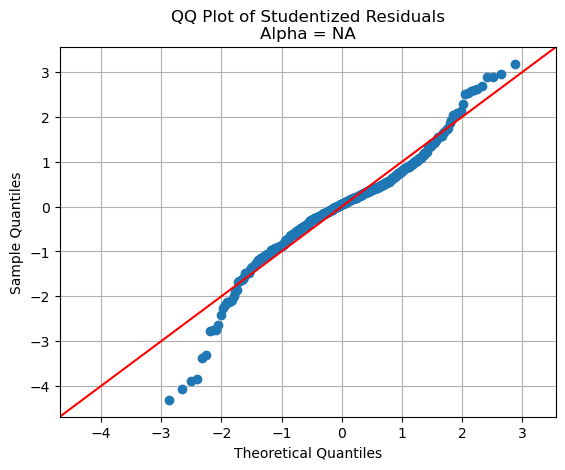

In [2156]:
res_v_true(test_msep0, "NA", 0.4)
qqres_plot(test_msep0, "NA")

In [2157]:
print(mae_calc_thresh(test_msep0, 0.5))
print(f_beta_wrapper(test_msep0, 0.5, 4))

(0.06965223880597014, 0.0665400468384075)
0.687170474516696


## MSE Poly 4

In [2158]:
folder = os.path.join(data, "msep4")
os.listdir(folder)
test_msep4 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_msep4.csv"))
all_dfs["MSE Poly 4"] = test_msep4
test_msep4

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.5924
1,ACH-000219,Drug_1163,0.9061,0.9061,0.5504
2,ACH-000222,Drug_1163,0.9846,0.9846,0.6698
3,ACH-000548,Drug_1163,0.9246,0.9246,0.5940
4,ACH-000288,Drug_1163,0.9222,0.9222,0.5511
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.5853
490,ACH-000704,Drug_1127,0.5981,0.5981,0.4284
491,ACH-000042,Drug_1127,0.6009,0.6009,0.5097
492,ACH-000677,Drug_1127,0.5345,0.5345,0.4904


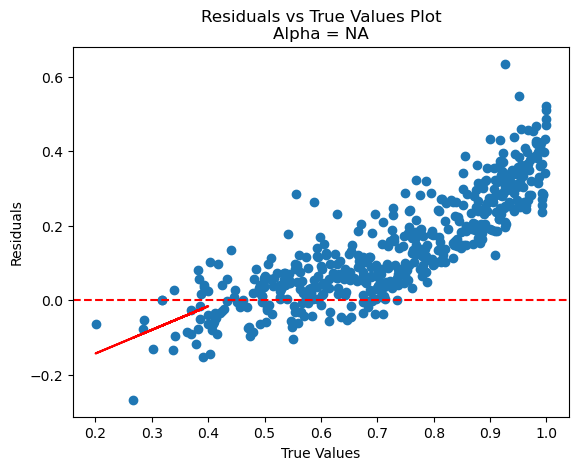

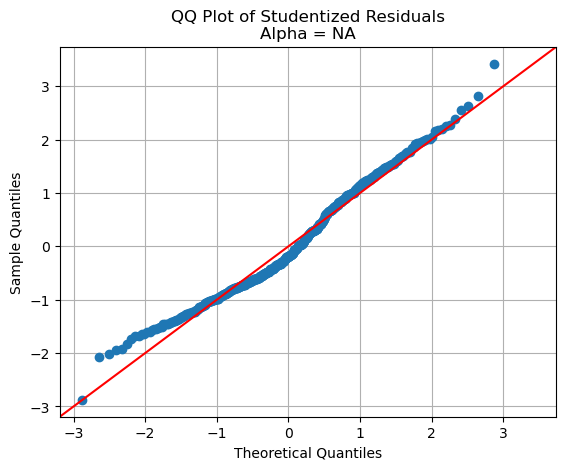

In [2159]:
res_v_true(test_msep4, "NA", 0.4)
qqres_plot(test_msep4, "NA")

In [2160]:
print(mae_calc_thresh(test_msep4, 0.5))
print(f_beta_wrapper(test_msep4, 0.5, 4))

(0.05713582089552239, 0.1755728337236534)
0.8177215189873418


## Quantiles Analysis

In [2161]:
for key, value in all_dfs.items():
    print(key)
    print(range_metrics(value, 0.2,0.8))

Base Case
{'Lower Quantile MAE': 0.08034747474747475, 'Lower Quantile Coverage': 0.7575757575757576, 'Upper Quantile MAE': 0.060868686868686864, 'Upper Quantile Coverage': 0.5454545454545454}
MAE Poly 2
{'Lower Quantile MAE': 0.06395151515151515, 'Lower Quantile Coverage': 0.7777777777777778, 'Upper Quantile MAE': 0.20700505050505053, 'Upper Quantile Coverage': 0.0}
MAE Poly 4
{'Lower Quantile MAE': 0.05872727272727272, 'Lower Quantile Coverage': 0.9393939393939394, 'Upper Quantile MAE': 0.3513818181818182, 'Upper Quantile Coverage': 0.0}
MAE Exponential 4
{'Lower Quantile MAE': 0.07004949494949494, 'Lower Quantile Coverage': 0.8383838383838383, 'Upper Quantile MAE': 0.11336262626262625, 'Upper Quantile Coverage': 0.23232323232323232}
MAE Exponential 7
{'Lower Quantile MAE': 0.056841414141414144, 'Lower Quantile Coverage': 0.8484848484848485, 'Upper Quantile MAE': 0.1786686868686869, 'Upper Quantile Coverage': 0.18181818181818182}
Log Cosh
{'Lower Quantile MAE': 0.07658585858585859, 'L

In [2162]:
interval_dict = []
for key, value in all_dfs.items():
    print(key)
    interval_dict.append(mae_intervals(value, key))
    
    
interval_df = pd.concat(interval_dict)
interval_df

Base Case
MAE Poly 2
MAE Poly 4
MAE Exponential 4
MAE Exponential 7
Log Cosh
MSE Poly 2
MSE Base
MSE Poly 4


,Interval,MAE,n,loss
0,"[0.0, 0.1)",NaN,0,Base Case
1,"[0.1, 0.2)",NaN,0,Base Case
2,"[0.2, 0.3)",0.123250,4,Base Case
3,"[0.3, 0.4)",0.072245,20,Base Case
4,"[0.4, 0.5)",0.075035,43,Base Case
...,...,...,...,...
5,"[0.5, 0.6)",0.060366,71,MSE Poly 4
6,"[0.6, 0.7)",0.074182,76,MSE Poly 4
7,"[0.7, 0.8)",0.120577,92,MSE Poly 4
8,"[0.8, 0.9)",0.218349,72,MSE Poly 4


/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/4154476075.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/4154476075.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/4154476075.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/4154476075.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

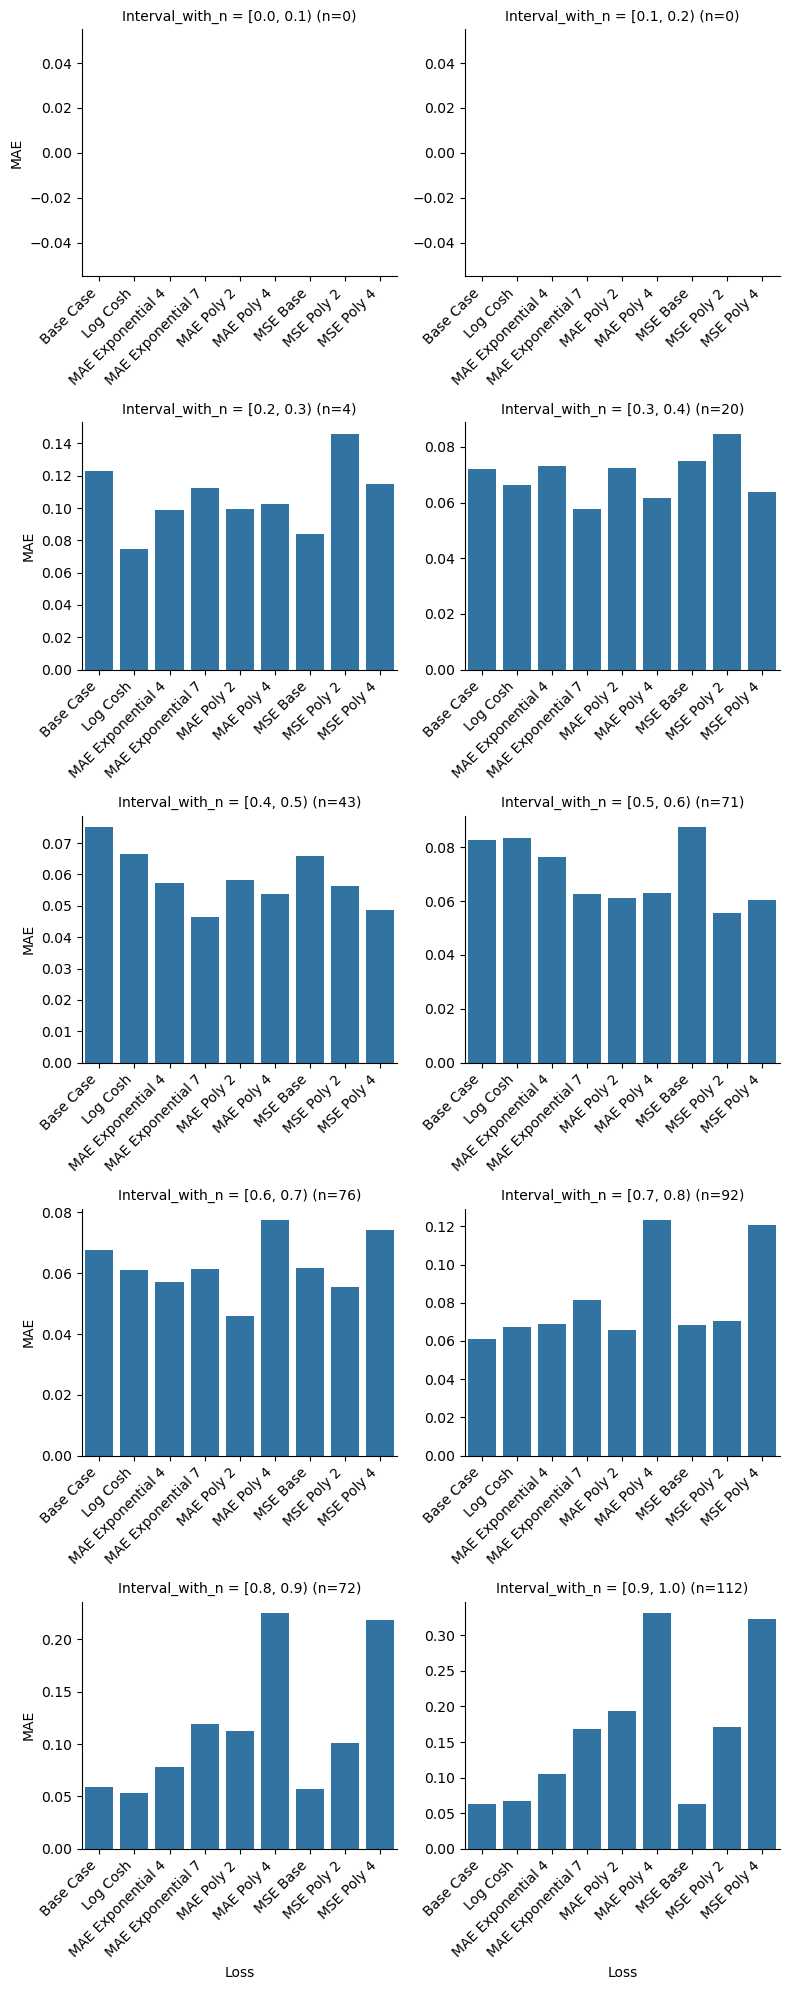

In [2163]:
# # Create the plot
# g = sns.FacetGrid(interval_df, col="Interval", sharex=False, sharey=False, height=4, col_wrap=2)
# g.map(sns.barplot, "loss", "MAE", order=interval_df["loss"].sort_values().unique())

# # Adjust and show the plot

# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# g.set_axis_labels("Loss", "MAE")
# g.set_titles(col_template="{col_name} (n={n})")
# g.tight_layout()
# plt.show()

interval_df["Interval_with_n"] = interval_df.apply(lambda row: f"{row['Interval']} (n={row['n']})", axis=1)

# Update the FacetGrid to use the new Interval_with_n column for titles
g = sns.FacetGrid(interval_df, col="Interval_with_n", sharex=False, sharey=False, height=4, col_wrap=2)
g.map(sns.barplot, "loss", "MAE", order=interval_df["loss"].sort_values().unique())

# Rotate x-axis labels
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Adjust and show the plot
g.set_axis_labels("Loss", "MAE")
g.tight_layout()
plt.show()


LOGSCALE

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/1354776902.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/1354776902.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/1354776902.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/1354776902.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

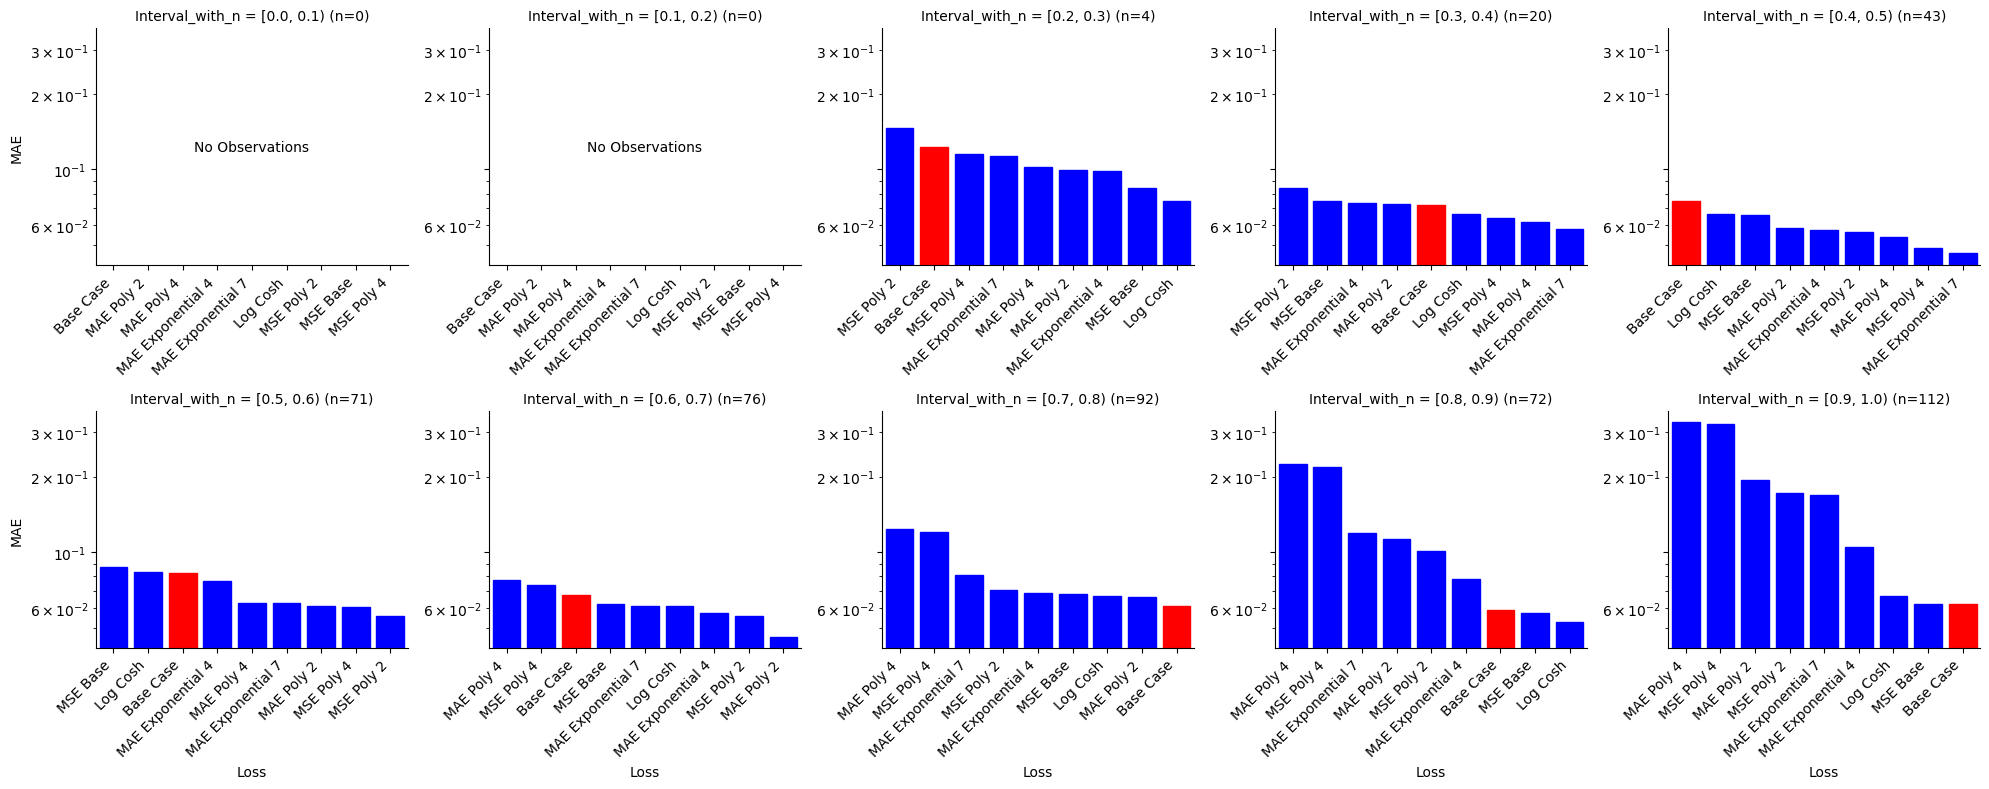

In [2164]:

# Assuming `interval_df` is your DataFrame
# Add a column for sorting by MAE within each interval
interval_df["MAE_rank"] = interval_df.groupby("Interval")["MAE"].rank(method="first", ascending=False)

# Define the bar colors; highlight a specific bar (e.g., for a specific loss function)
highlight_loss = "Base Case"  # Replace this with the loss function to highlight
interval_df["bar_color"] = interval_df["loss"].apply(lambda x: "red" if x == highlight_loss else "blue")

# Create the plot
g = sns.FacetGrid(interval_df, col="Interval_with_n", sharex=False, sharey=True, height=4, col_wrap=5)

# Define a plotting function without palette
def custom_barplot(data, **kwargs):
    data = data.sort_values("MAE_rank")  # Sort data by MAE rank
    ax = sns.barplot(data=data, x="loss", y="MAE", **kwargs)
    
    # Apply custom colors after the bars are drawn
    for bar, color in zip(ax.patches, data["bar_color"]):
        bar.set_color(color)

# Map the custom barplot function
g.map_dataframe(custom_barplot)

# Rotate x-axis labels
for ax, interval in zip(g.axes.flat, g.col_names):
    # Check if the interval has positive MAE values
    subset = interval_df[interval_df["Interval_with_n"] == interval]
    if subset["MAE"].gt(0).any():  # Only apply log scale if there are positive values
        ax.set_yscale("log")
    else:
        # Add a note to indicate no valid values
        ax.text(0.5, 0.5, "No Observations", ha="center", va="center", transform=ax.transAxes)
    
    # Rotate x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Adjust and show the plot
g.set_axis_labels("Loss", "MAE")
g.tight_layout()
plt.show()
